### Cleaning the Data

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np


In [2]:
df = pd.read_csv('data/bankloan.csv')

In [3]:
# Drop ID and ZipCode (not useful for prediction)
df.drop(['ID', 'ZIP.Code'], axis=1, inplace=True)

In [4]:
# Features and Target
X = df.drop('Personal.Loan', axis=1)
y = df['Personal.Loan']

In [5]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [31]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
print("Data is ready.")
print("X_train shape:", X_train.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))

Data is ready.
X_train shape: (4000, 11)
y_train distribution:
 Personal.Loan
0    0.904
1    0.096
Name: proportion, dtype: float64


### Building Model with Keras

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [ ]:
# Class weight works only with numpy arrays
y_train = y_train.to_numpy()


In [34]:
# Compute class weights to handle imbalance
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# Properly map weights to actual class labels
class_weight_dict = dict(zip(classes, class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: 0.5530973451327433, 1: 5.208333333333333}


In [35]:
# Build the model
model = Sequential([
    Input(shape=(X_train.shape[1],)), 
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [36]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

In [37]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/20


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7323 - auc: 0.7725 - loss: 0.6018 - val_accuracy: 0.8537 - val_auc: 0.9494 - val_loss: 0.4053
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8616 - auc: 0.9402 - loss: 0.3558 - val_accuracy: 0.8988 - val_auc: 0.9620 - val_loss: 0.2405
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8978 - auc: 0.9669 - loss: 0.2481 - val_accuracy: 0.8800 - val_auc: 0.9660 - val_loss: 0.2718
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8989 - auc: 0.9653 - loss: 0.2447 - val_accuracy: 0.9013 - val_auc: 0.9713 - val_loss: 0.2387
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9032 - auc: 0.9738 - loss: 0.2126 - val_accuracy: 0.9137 - val_auc: 0.9752 - val_loss: 0.1988
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9243 - auc: 0.9797 - loss: 0.1848 - val_accuracy: 0.9112 - val_auc: 0.9765 - val_loss: 0.1910
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

### Evaluating the Model

In [38]:
loss, accuracy, auc = model.evaluate(X_test, y_test.to_numpy(), verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")


Test Loss: 0.1300
Test Accuracy: 0.9500
Test AUC: 0.9936


In [39]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [40]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       904
           1       0.66      0.97      0.79        96

    accuracy                           0.95      1000
   macro avg       0.83      0.96      0.88      1000
weighted avg       0.96      0.95      0.95      1000

[[857  47]
 [  3  93]]


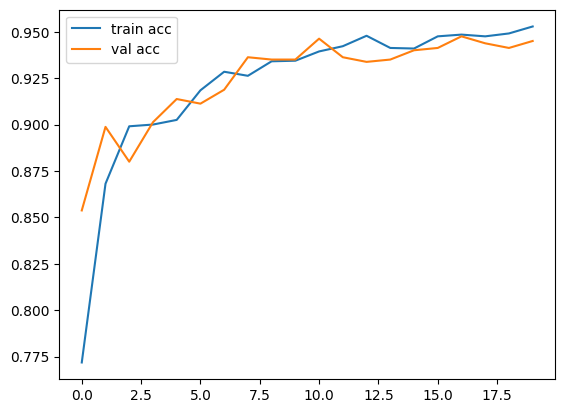

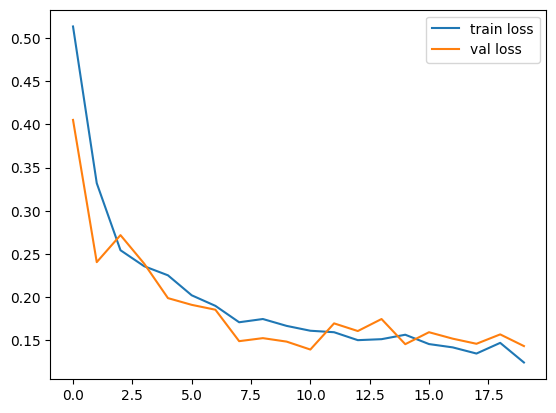

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


### Saving Model

In [45]:
model.save("bankloan_model.keras") 